# Testing Notebook

**Note:** This Jupyter notebook is for testing and playing around with the data. It is not a final product. Let me know if you have problems with it in Github Issues.

In [11]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns

In [12]:
multichoice = pd.read_csv('cleaned_multichoice.csv')
# print(multichoice.head())

## Correlation matrix
The first visualization, the correlation matrix, is used to find columns that relate to each other or *correlate*. This can help brainstorm ideas for future visualizations. My code below randomly chooses 10 columns from the cleaned data and analyzes the correlation.


You only need to look at the data under and to the left of the red squares as it is mirrored to the other side.

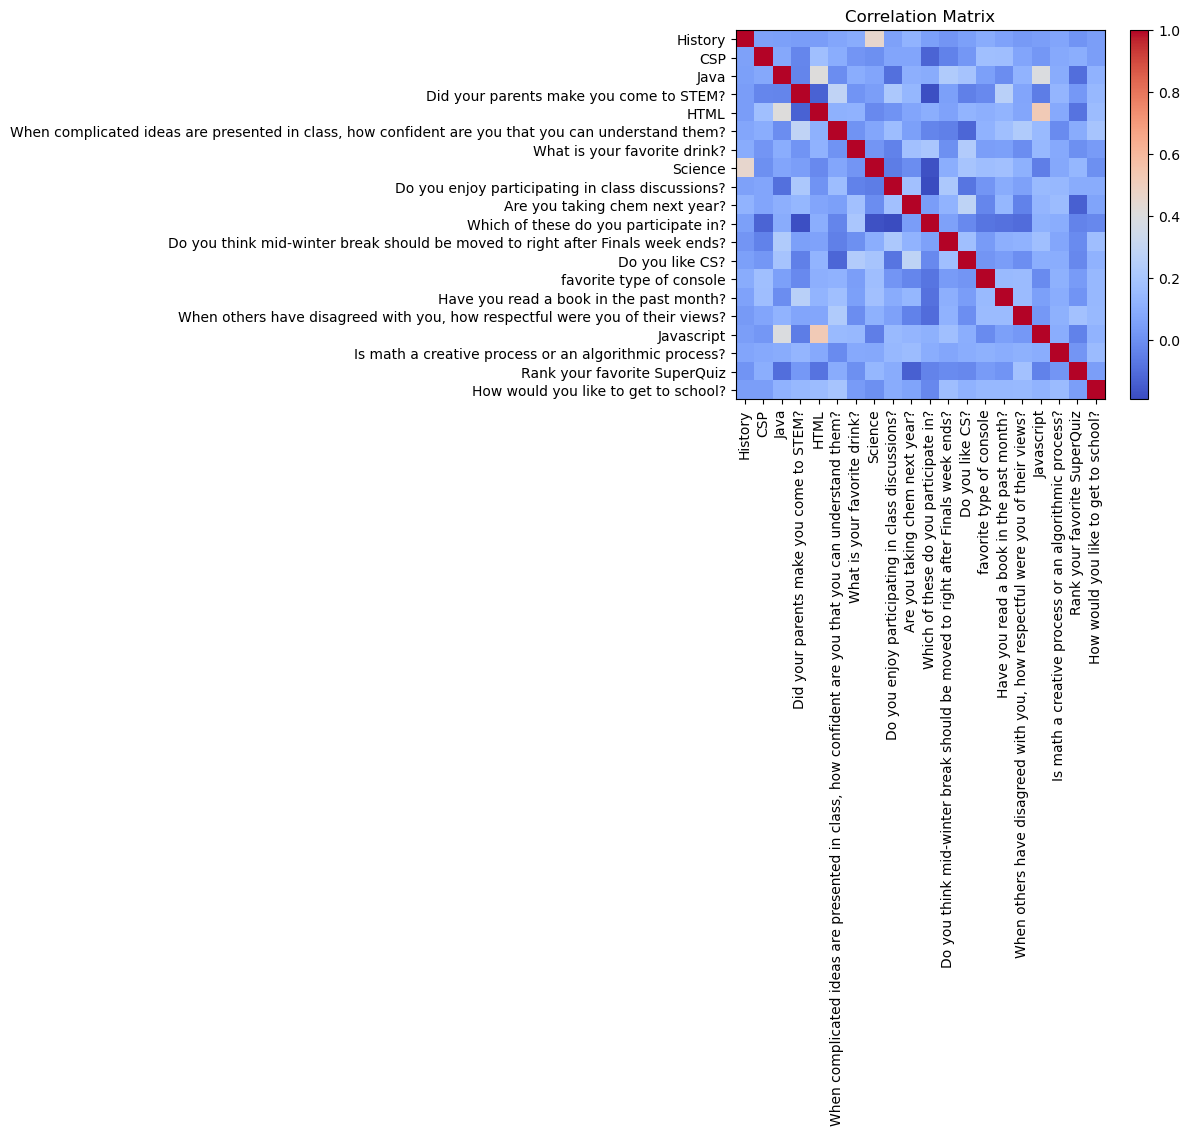

In [13]:
selected_columns = np.random.choice(
    multichoice.columns, size=20, replace=False)
random_multichoice = multichoice[selected_columns]
corr_matrix = random_multichoice.corr()

# Plotting the correlation matrix
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.show()


c:\Users\Parthiv\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Parthiv\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Parthiv\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Parthiv\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.type

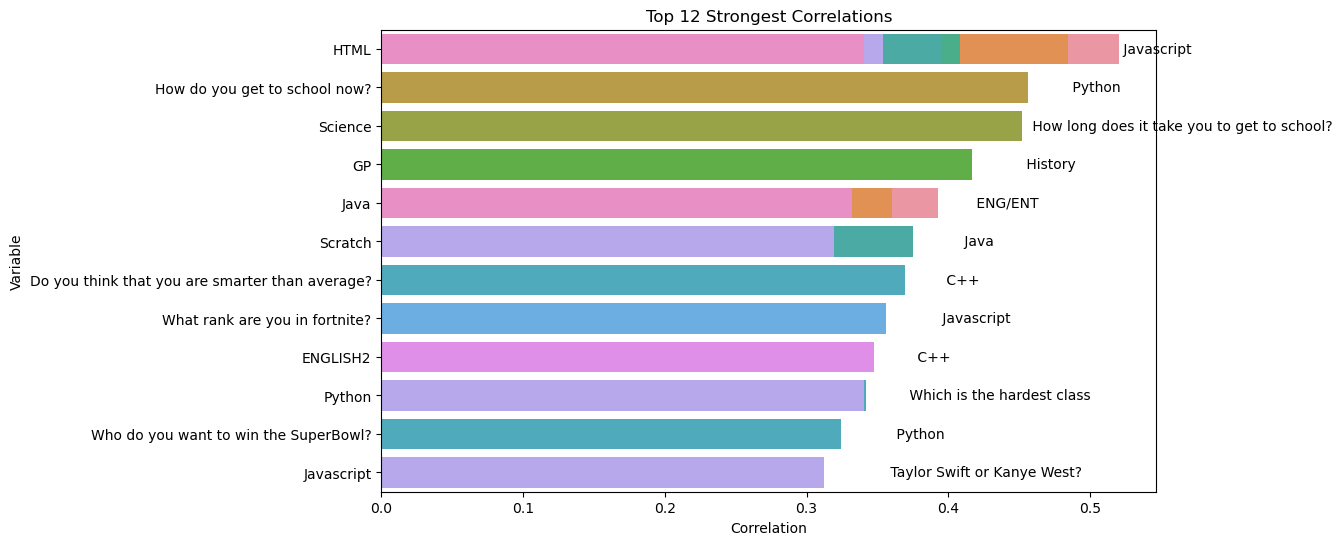

In [14]:
strongest_corr_matrix = multichoice.corr()

# Correlations can be positive or negative depending on the relationship and the direction but we just care about the strength of the correlation
abs_corr = strongest_corr_matrix.abs()

# Create a mask to remove the upper triangle and the diagonal
mask = np.triu(np.ones_like(abs_corr, dtype=bool))
masked_corr = abs_corr.mask(mask)

# Get the top 12 correlations, dropna to remove NaNs
# Taking the first 22 because of something I can't figure out but works.
top_corr = masked_corr.unstack().dropna().sort_values(ascending=False).head(22)
top_corr_df = pd.DataFrame(top_corr, columns=['Correlation'])
top_corr_df = top_corr_df.reset_index().rename(
    columns={'level_0': 'Variable 1', 'level_1': 'Variable 2'})

# Plot the correlations
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top_corr_df, x='Correlation',
                 y='Variable 1', hue='Variable 2', dodge=False)

# Remove the legend
ax.legend_.remove()

# Annotate each bar with the corresponding "Variable 2" value
bar_count = 0
for i, (var1, var2, corr) in enumerate(top_corr_df.values):
    if bar_count < 12:
        ax.text(corr, i, f' {var2}', color='black', ha="left", va="center")
        bar_count += 1

plt.title('Top 12 Strongest Correlations')
plt.xlabel('Correlation')
plt.ylabel('Variable')
plt.show()

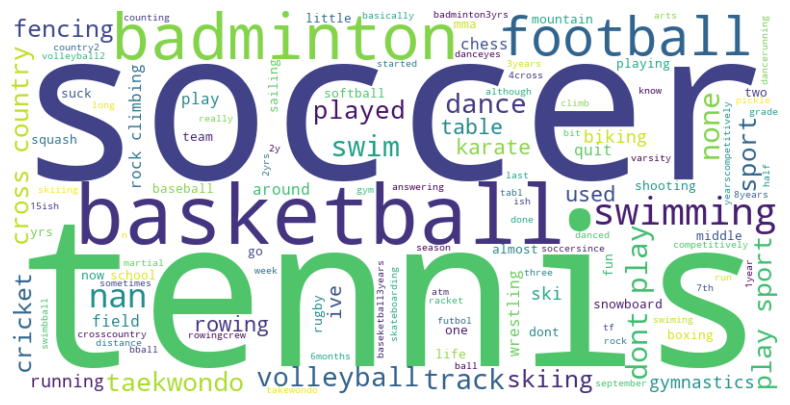

In [15]:
from wordcloud import WordCloud
import re
uncleaned_data = pd.read_csv('ninthdata.csv')
# print(uncleaned_data.head())

sport_data = uncleaned_data[["What sport do play? How long have you played that sport?", "What's the best sport?", "What sports do you play?"]]
# print(sport_data.head())

sport_data.to_csv('cleaned_sport.csv', index=False)

text = " ".join(sport_data['What sport do play? How long have you played that sport?'].astype(str) + " " +
                sport_data["What's the best sport?"].astype(str) + " " +
                sport_data['What sports do you play?'].astype(str))

text = text.lower()
text = re.sub(r'[^\w\s]', '', text)
text = re.sub(r'\s+', ' ', text).strip()

# List of unnecessary words to remove
stopwords = set(["year", "years", "month", "months", "for", "about", "the",
                "a", "and", "in", "to", "i", "this", "that", "have", "been", "of"])
filtered_text = " ".join(
    [word for word in text.split() if word not in stopwords])

wordcloud = WordCloud(width=800, height=400,
                      background_color='white').generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

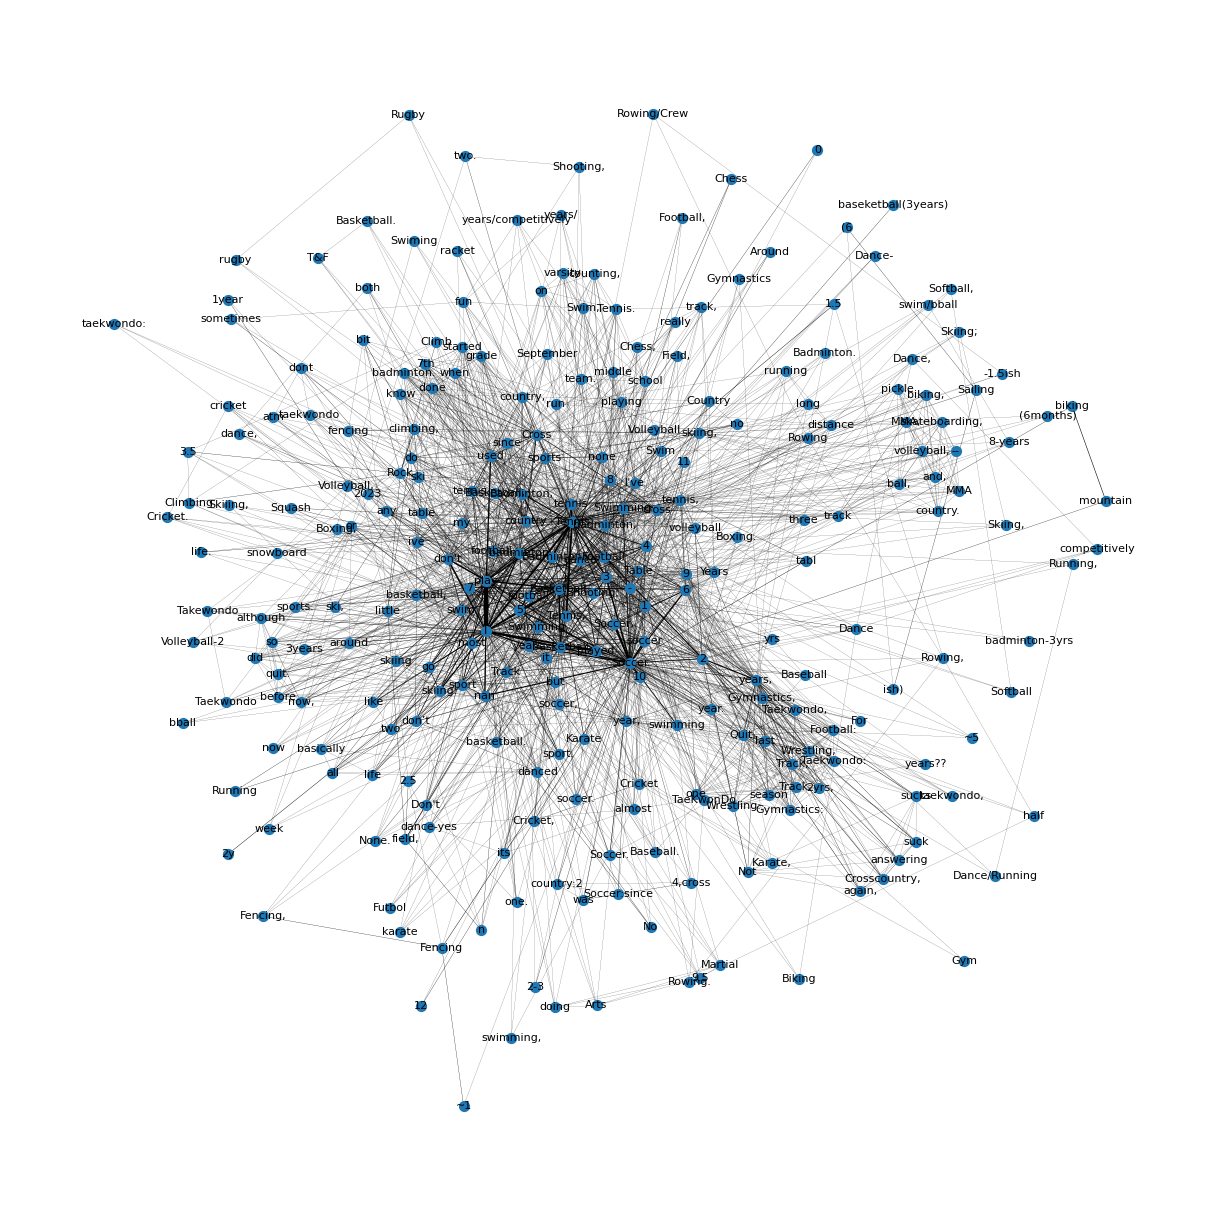

In [16]:
from collections import Counter
import networkx as nx
# Combine all the text data into one large string
text = " ".join(sport_data['What sport do play? How long have you played that sport?'].astype(str) + " " +
                sport_data["What's the best sport?"].astype(str) + " " +
                sport_data['What sports do you play?'].astype(str))

# Clean text
text = text.lower()
text = re.sub(r'[^\w\s]', '', text)
text = re.sub(r'\s+', ' ', text).strip()

# Remove unnecessary words
stopwords = set(["year", "years", "month", "months", "for", "about", "the",
                "a", "and", "in", "to", "i", "this", "that", "have", "been", "of"])
filtered_text = " ".join(
    [word for word in text.split() if word not in stopwords])

words = filtered_text.split()
word_counts = Counter(words)
word_freq_df = pd.DataFrame(word_counts.items(), columns=[
                            'Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
rows = sport_data.apply(lambda x: " ".join(
    x.astype(str)).split(), axis=1).tolist()

# Create a co-occurrence matrix
co_occurrences = Counter()
for row in rows:
    for i in range(len(row)):
        for j in range(i+1, len(row)):
            if row[i] not in stopwords and row[j] not in stopwords:
                co_occurrences[frozenset([row[i], row[j]])] += 1

# Create and draw the graph
G = nx.Graph()
for pair, freq in co_occurrences.items():
    if len(pair) == 2:  # Ensure the pair has exactly two elements
        word1, word2 = tuple(pair)
        G.add_edge(word1, word2, weight=freq)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_size=50, font_size=8,
        width=[G[u][v]['weight']/10 for u, v in G.edges()])
plt.show()